In [1]:
#Importing the dataframe from Excel

import pandas as pd

df=pd.read_excel('C:/Users/vikra/.spyder-py3/CMC Database.xlsx', sheet_name = 'Sheet4', header=0)

print(df)

     Serial No.  Surfactant No.        Charge           Surfactant Name  \
0             1             1.0       Anionic  Sodium Dodecyl 1 Sulfate   
1             2             NaN       Anionic  Sodium Dodecyl 1 Sulfate   
2             3             2.0       Anionic    Sodium Octyl 1 Sulfate   
3             4             NaN       Anionic    Sodium Octyl 1 Sulfate   
4             5             3.0       Anionic    Sodium Decyl 1 Sulfate   
..          ...             ...           ...                       ...   
262         263           256.0  Zwitterionic  C12H25N+(CH3)2(CH2)5COO−   
263         264           257.0  Zwitterionic  C12H25N+(CH3)2(CH2)7COO−   
264         265           258.0  Zwitterionic     C8H17CH(COO-)N+(CH3)3   
265         266           259.0  Zwitterionic    C10H21CH(COO-)N+(CH3)3   
266         267           260.0  Zwitterionic    C12H25CH(COO-)N+(CH3)3   

    Formula                   Head Group  \
0       NaN                      Sulfate   
1       NaN

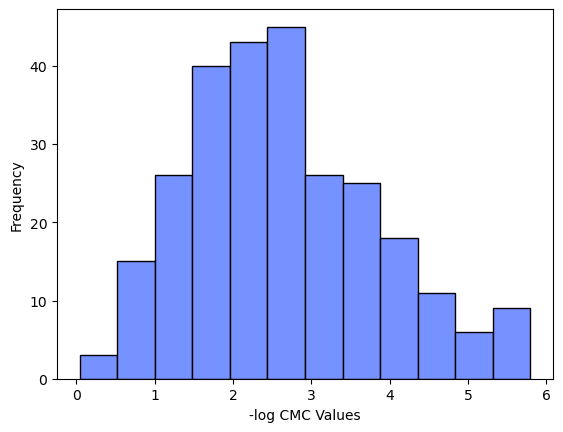

In [47]:
#CMC Data histogram

x = df['-log CMC']

plt.hist(x, bins=12,color='#7692FF', edgecolor='black')


plt.xlabel('-log CMC Values')
plt.ylabel('Frequency')



## Axes
ax1.titlesize : 8
ax1.labelsize : 8

In [3]:
# Identify target column (output). For this example, wine quality is the target property
target = ['-log CMC']
# Identify features (inputs)
features = (list(set(list(df.columns))-set(target)))
# Print features
features

['Surfactant Name',
 'Formula',
 'Head Group',
 'SMILES Representation',
 'Serial No.',
 'Surfactant No.',
 '2^-log(CMC)',
 'Temp (oC)',
 'CMC (M)',
 'Charge']

In [4]:
headers = df.columns.tolist()
headers

['Serial No.',
 'Surfactant No.',
 'Charge',
 'Surfactant Name',
 'Formula',
 'Head Group',
 'SMILES Representation',
 'Temp (oC)',
 'CMC (M)',
 '-log CMC',
 '2^-log(CMC)']

In [5]:
#Creating dataset with only required data

df2 = df.drop(df.columns[[0,1,2,3,4,5,8,10]], axis= 1)
#df2 = df2.drop([28,29,51])


#df2 = df2.loc[130:135, :]
#df2 = df2.reset_index()
#df2 = df2.drop(['index'], axis= 1)

df2

,SMILES Representation,Temp (oC),-log CMC
0,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,2.072117
1,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],25,2.080922
2,CCCCCCCCOS(=O)(=O)[O-].[Na+],20,0.873869
3,CCCCCCCCOS(=O)(=O)[O-].[Na+],25,0.885056
4,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],20,1.474955
...,...,...,...
262,CCCCCCCCCCCC[N+](C)(C)CCCCCC(=O)[O-],25,2.585027
263,CCCCCCCCCCCC[N+](C)(C)CCCCCCCC(=O)[O-],25,2.823909
264,CCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.013228
265,CCCCCCCCCCC(C(=O)[O-])[N+](C)(C)C,27,1.886057


In [6]:
#Checks to see if there is any null values within each of the columns of the database.
df2.isnull().sum()

SMILES Representation    0
Temp (oC)                0
-log CMC                 0
dtype: int64

In [7]:
import numpy as np
import rdkit as rd
from rdkit import Chem, DataStructs, rdBase
#draw the molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AtomPairs
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect

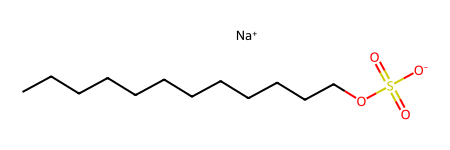

In [8]:
smile = df2.iloc[0,0]
mol = Chem.MolFromSmiles(smile)
mol

In [9]:
#Create a function that will convert the smiles into a morgan fingerprint
def MoleculeGen(rad: int, dataframe: pd.DataFrame) -> pd.DataFrame:
    #initilise empty lists for holding the mol drawings and morgan fingerprints
    mol_list = []
    fin_list = []
    i = 0
    
    for smile in dataframe['SMILES Representation']:
        i += 1
        try:
            #Generate the molecular drawing of the smile
            mol = Chem.MolFromSmiles(smile)
            mol_list.append(mol)
            #Generate the morgan fingerprint of the smile in question
            mf_bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius= rad, nBits= 2**8)
            #initialise a temporary array that will have the bit vector mapped onto to convert from bit vector to numpy array\
            #(this is because we can only use np arrays and not bit vectors within python)
            temp = np.zeros((0,), dtype= np.int8)
            DataStructs.ConvertToNumpyArray(mf_bitvect, temp)
            fin_list.append(temp)
           
        except:
            print(i, smile)
    #convert the np array to a dataframe that we can then add to the main dataframe in question
    fin_list = pd.DataFrame(fin_list)
    #Add the fingerprint list to the main dataframe along the columns (axis = 1)
    dataframe = pd.concat([dataframe, fin_list], axis= 1)
    return dataframe

In [10]:
#Call the function to generate the fingerprints
df3 = MoleculeGen(7, df2)

#drop the smile columns since this will  not be passed to the machine learning model
df3 = df3.drop(['SMILES Representation'], axis = 1)
#denote the target heading
target = ['-log CMC']
#define all other headings as the input features for the model
features = (list(set(list(df3.columns))-set(target)))
#get the values of the input features and output features
x_data = df3[features].values
y_data = df3[target].values
x_data.shape

df3

[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerator
[19:22:33] DEPRECATION WARNING: please use MorganGenerat

,Temp (oC),-log CMC,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,20,2.072117,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,25,2.080922,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,20,0.873869,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,25,0.885056,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,20,1.474955,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,25,2.585027,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
263,25,2.823909,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
264,27,1.013228,0,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
265,27,1.886057,0,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [11]:
# Import scikit learn classifier and regressor.
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# Tool for splitting sets. Needed to split training and test data
from sklearn.model_selection import train_test_split

# Module to normalized data
from sklearn import preprocessing

# Tool for calculation of the mean square error (mse)
from sklearn.metrics import mean_squared_error

# Tool for calculating R2 score
from sklearn.metrics import r2_score


# Split data for training and testing. In this example, the splits is 80:20
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.2,random_state=5,shuffle=True)

print(x_train.shape)
print(x_test.shape)

(213, 257)
(54, 257)


In [13]:

# Create an Artificial Neural Network architecture 
clf = MLPRegressor(hidden_layer_sizes=(4),solver='lbfgs',alpha=1e-5,random_state=5,max_iter=2000)

# Fit data to the ANN
clf.fit(x_train,y_train.ravel())
r2 = clf.score(x_train,y_train.ravel())
print('The R2 after fitting is: {0:6.5f}'.format(r2))

The R2 after fitting is: 0.99197


In [14]:
#MSE / RRMSE of Data
predict_train_set = clf.predict(x_train)
predict_test_set = clf.predict(x_test)
mse = mean_squared_error(y_data, clf.predict(x_data))
#rmse = (mean_squared_error(y_data, clf.predict(x_data)))**(0.5) 
print(mse)

0.056285466010267515


In [15]:
#Test dataset MSE
mean_squared_error(y_test, predict_test_set)

0.2310036257662708

In [16]:
#Training dataset MSE
mean_squared_error(y_train, predict_train_set)

0.011990721283393445

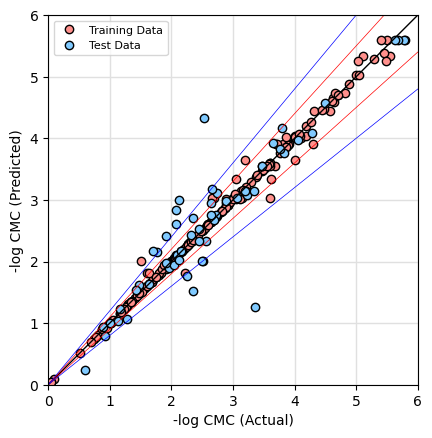

<Figure size 5940x5400 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#plt.figure(figsize=(12,8))
ax1=plt.subplot(1, 1, 1)

ax1.plot(y_train,predict_train_set,marker='o',ls='None',mec='k',mfc='#FF908C',label='Training Data')
ax1.plot(y_test,predict_test_set,marker='o',ls='None',mec='k',mfc='#80CAFF',label='Test Data')
ax1.legend(fontsize=8, framealpha=0.8) #edgecolor=1?????


graph_size = 6


ax1.plot([0,graph_size],[0,graph_size],'-k',lw=1)
ax1.plot([0,graph_size],[0,graph_size*0.9],'-r',lw=0.5)
ax1.plot([0,graph_size],[0,graph_size*1.1],'-r',lw=0.5)
ax1.plot([0,graph_size],[0,graph_size*0.8],'-b',lw=0.5)
ax1.plot([0,graph_size],[0,graph_size*1.2],'-b',lw=0.5)


ax1.set_xlim([0,graph_size])
ax1.set_ylim([0,graph_size])
ax1.set_xlabel('-log CMC (Actual)') #size=18, if you want to change font size
ax1.set_ylabel('-log CMC (Predicted)')
# ax1.set_title('Actual vs Predicted -log CMC values') #No titles in scientific figures

#ax1.grid()
plt.gca().set_aspect('equal', adjustable='box')

## Figure property 
figure(figsize=(3.3, 3), dpi=1800) # for figsize: width, height in inches
#ax1.autolayout : true # for labels not being cut out

## Axes
ax1.titlesize : 8
ax1.labelsize : 8
#ax1.formatter.limits : -5

## Grid
ax1.grid(True, color='#e0e0e0', which='both', linewidth=1)


## Lines & Scatter
# lines.linewidth : 1
# lines.markersize : 2
# scatter.marker: o

#ax1.xticks(ticks=True, labels=None, *, minor=False)

## Fonts
# font.family : arial
# font.weight : normal
# font.size : 10

#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("Picture - Basic CMC ML Model.png", format='png')
plt.show()


In [18]:
#Finding the number of predictions that are more than 20% inaccurate

iterations = y_test.size

log_CMC_list = []

for i in range(0,iterations):
    q = predict_test_set[i]/y_test[i]
    if q > 1.2 or q < 0.8:
        log_CMC_list.append(y_test[i])
    i += 1

print(len(log_CMC_list)*100/iterations)
print('No. of predictions with accuracy lower than 80%:', len(log_CMC_list))
print('Size of test dataset:', iterations)

20.37037037037037
No. of predictions with accuracy lower than 80%: 11
Size of test dataset: 54


In [20]:
# filter rows based on list values

# surfactant_head_group = 'Glucoside' #INSERT HEAD GROUP NAME HERE!!!!!!!!!!!!!!

# head_group_list=[surfactant_head_group]
# filter = df['Head Group'].isin(head_group_list)
# required_surfactants = df[filter]
# required_surfactants


#For charged-based filtering
head_group_charge = 'Non-ionic' #INSERT CHARGE NAME HERE!!!!!!!!!!!!!!

charge_list=[head_group_charge]
filter = df['Charge'].isin(charge_list)
required_surfactants = df[filter]
required_surfactants

,Serial No.,Surfactant No.,Charge,Surfactant Name,Formula,Head Group,SMILES Representation,Temp (oC),CMC (M),-log CMC,2^-log(CMC)
21,22,15.0,Non-ionic,Octylphenol diethoxylate,(CH3)3C(CH3)2CC6H4(OC2H4)2OH,Phenolethoxylate,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCO,25,0.000132,3.879426,70.950692
22,23,16.0,Non-ionic,Octylphenol triethoxylate,(CH3)3C(CH3)2CC6H4(OC2H4)3OH,Phenolethoxylate,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCOCCO,25,0.000097,4.013228,82.185747
23,24,17.0,Non-ionic,Octylphenol tetraethoxylate,(CH3)3C(CH3)2CC6H4(OC2H4)4OH,Phenolethoxylate,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCOCCOCCO,25,0.000125,3.903090,72.819416
24,25,18.0,Non-ionic,Octylphenol pentaethoxylate,(CH3)3C(CH3)2CC6H4(OC2H4)5OH,Phenolethoxylate,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCOCCOCCOCCO,25,0.000154,3.812479,65.919651
25,26,19.0,Non-ionic,Octylphenol hexaethoxylate,(CH3)3C(CH3)2CC6H4(OC2H4)6OH,Phenolethoxylate,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCOCCOCCOCCOCCO,25,0.000205,3.688246,57.509637
...,...,...,...,...,...,...,...,...,...,...,...
183,184,177.0,Non-ionic,C6F13C2H4SC2H4(OC2H4)5OH,NaN,Fluorinated alkyls,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)CCS...,25,0.003700,2.431798,14.463142
184,185,178.0,Non-ionic,C6F13C2H4SC2H4(OC2H4)7OH,NaN,Fluorinated alkyls,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)CCS...,25,0.004800,2.318759,12.774064
185,186,179.0,Non-ionic,(CH3)3SiOSi(CH3)[CH2(C2H4O)5H]OSi(CH3)3,NaN,Siloxane-Based,C[Si](C)(C)O[Si](C)(CCCOCCOCCOCCOCCO)O[Si](C)(C)C,23,0.000079,4.102373,90.641965
186,187,180.0,Non-ionic,(CH3)3SiOSi(CH3)[CH2(C2H4O)9H]OSi(CH3)3,NaN,Siloxane-Based,C[Si](C)(C)O[Si](C)(CCCOCCOCCOCCOCCOCCOCCOCCOC...,23,0.000100,4.000000,81.000000


In [21]:
df4 = required_surfactants.drop(required_surfactants.columns[[0,1,2,3,4,5,8,10]], axis= 1)
df4

df4 = df4.reset_index()
df4 = df4.drop(['index'], axis= 1)


In [22]:
df5 = MoleculeGen(7, df4)
df5

[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:40] DEPRECATION WARNING: please use MorganGenerator
[19:22:41] DEPRECATION WARNING: please use MorganGenerator
[19:22:41] DEPRECATION WARNING: please use MorganGenerator
[19:22:41] DEPRECATION WARNING: please use MorganGenerator
[19:22:41] DEPRECATION WARNING: please use MorganGenerator
[19:22:41] DEPRECATION WARNING: please use MorganGenerator
[19:22:41] DEPRECATION WARNING: please use MorganGenerator
[19:22:41] DEPRECATION WARNING: please use MorganGenerat

,SMILES Representation,Temp (oC),-log CMC,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,253,254,255
0,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCO,25,3.879426,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCOCCO,25,4.013228,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCOCCOCCO,25,3.903090,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCOCCOCCOCCO,25,3.812479,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,CC(C)(C)CC(C)(C)C1=CC=C(C=C1)OCCOCCOCCOCCOCCOCCO,25,3.688246,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)CCS...,25,2.431798,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
134,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)CCS...,25,2.318759,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
135,C[Si](C)(C)O[Si](C)(CCCOCCOCCOCCOCCO)O[Si](C)(C)C,23,4.102373,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
136,C[Si](C)(C)O[Si](C)(CCCOCCOCCOCCOCCOCCOCCOCCOC...,23,4.000000,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1


In [23]:
#drop the smile columns since this will  not be passed to the machine learning model
df5 = df5.drop(['SMILES Representation'], axis = 1)
#denote the target heading
target = ['-log CMC']
#define all other headings as the input features for the model
features = (list(set(list(df5.columns))-set(target)))
#get the values of the input features and output features
X_data = df5[features].values
Y_data = df5[target].values

In [24]:
X_data

array([[ 0,  0,  1, ...,  0,  0, 25],
       [ 0,  0,  1, ...,  0,  0, 25],
       [ 0,  0,  1, ...,  0,  0, 25],
       ...,
       [ 0,  0,  0, ...,  0,  1, 23],
       [ 0,  0,  0, ...,  0,  1, 23],
       [ 0,  0,  0, ...,  0,  1, 23]], dtype=int64)

In [25]:
predict_sub_set = clf.predict(X_data)

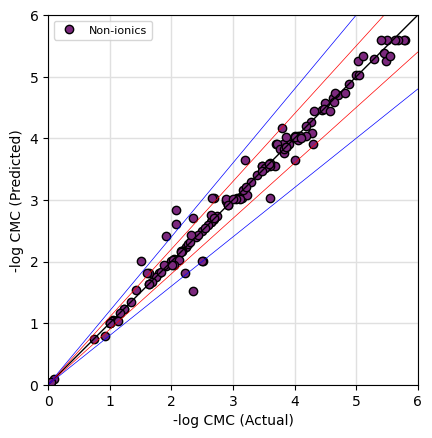

<Figure size 5940x5400 with 0 Axes>

In [26]:
#plt.figure(figsize=(12,8))
ax1=plt.subplot(1, 1, 1)

#ax1.plot(Y_data,predict_sub_set,marker='o',ls='None',mec='k',mfc='#CAD2C5',label=surfactant_head_group+'s') #Head Group

ax1.plot(Y_data,predict_sub_set,marker='o',ls='None',mec='k',mfc='#7B287D',label=head_group_charge+'s') #Charge

ax1.legend(fontsize=8, framealpha=0.8) #edgecolor=1?????


graph_size = 6


ax1.plot([0,graph_size],[0,graph_size],'-k',lw=1)
ax1.plot([0,graph_size],[0,graph_size*0.9],'-r',lw=0.5)
ax1.plot([0,graph_size],[0,graph_size*1.1],'-r',lw=0.5)
ax1.plot([0,graph_size],[0,graph_size*0.8],'-b',lw=0.5)
ax1.plot([0,graph_size],[0,graph_size*1.2],'-b',lw=0.5)


ax1.set_xlim([0,graph_size])
ax1.set_ylim([0,graph_size])
ax1.set_xlabel('-log CMC (Actual)') #size=18, if you want to change font size
ax1.set_ylabel('-log CMC (Predicted)')
# ax1.set_title('Actual vs Predicted -log CMC values') #No titles in scientific figures

#ax1.grid()
plt.gca().set_aspect('equal', adjustable='box')

## Figure property 
figure(figsize=(3.3, 3), dpi=1800) # for figsize: width, height in inches
#ax1.autolayout : true # for labels not being cut out

## Axes
ax1.titlesize : 8
ax1.labelsize : 8
#ax1.formatter.limits : -5

## Grid
ax1.grid(True, color='#e0e0e0', which='both', linewidth=1)


## Lines & Scatter
# lines.linewidth : 1
# lines.markersize : 2
# scatter.marker: o

#ax1.xticks(ticks=True, labels=None, *, minor=False)

## Fonts
# font.family : arial
# font.weight : normal
# font.size : 10

#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("Picture - Basic CMC ML Model.png", format='png')
plt.show()

In [27]:
mean_squared_error(Y_data, predict_sub_set)

0.035685408402247